# (02) Amort-Enc—0

**Motivation**: Amortized inference, with residual mlp encoder. Device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from analysis.eval import sparse_score
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
device_idx = 0
device = f'cuda:{device_idx}'

model_type = 'poisson'

## MLP

In [3]:
kws_vae = dict(enc_type='mlp', enc_bias=True, rmax_q=1.0)
kws_tr = dict(kl_beta=1.0)

vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**kws_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**kws_tr), device=device)

In [4]:
vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}")

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|  PoissonVAE |  2.4 Mil   |
|     ---     |    ---     |
|     enc     |  2.1 Mil   |
|    fc_enc   |  131.6 K   |
|    fc_dec   |  131.1 K   |
+-------------+------------+

poisson_uniform_c(-3)_rmax(1)_DOVES_z-512_k-32_<mlp+b|lin>_wn
ep3600-b1000-lr(0.005)_beta(1:0x0.5)_temp(0.05:exp-1)_gr(500)

In [5]:
vae.fc_dec.bias, vae.fc_enc.bias.shape

(None, torch.Size([512]))

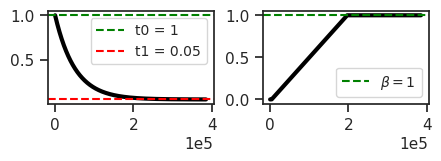

In [6]:
tr.show_schedules()

## Train

In [7]:
# comment = f"..._{tr.cfg.name()}"
comment = tr.cfg.name()
tr.train(comment=comment)

epoch # 3600, avg loss: 164.331031: 100%|███████████████████████| 3600/3600 [49:26<00:00,  1.21it/s]


In [7]:
## Was rmax_q = 0.99

epoch # 3600, avg loss: 164.341134: 100%|███████████████████████| 3600/3600 [38:13<00:00,  1.57it/s]


In [8]:
## Was rmax_q = 1.0

epoch # 3600, avg loss: 164.334596: 100%|███████████████████████| 3600/3600 [44:55<00:00,  1.34it/s]


In [8]:
print(vae)

PoissonVAE(
  (mse): MSELoss()
  (enc): DenseResBlock(
    (fc1): Linear(in_features=256, out_features=4096, bias=True)
    (fc2): Linear(in_features=4096, out_features=256, bias=True)
    (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (drop): Dropout(p=0.1, inplace=False)
    (relu): ReLU()
  )
  (fc_enc): Linear(in_features=256, out_features=512, bias=True)
  (fc_dec): Linear(in_features=512, out_features=256, bias=False)
)

## Eval

### Loss vld (freeze)

In [9]:
data, loss, rates = tr.validate()

_loss = {k: v.mean() for k, v in loss.items()}
_loss['tot'] = _loss['mse'] + _loss['kl']
print(_loss)

{'mse': 134.49945, 'kl': 29.589838, 'kl_diag': 0.05727961, 'tot': 164.0893}

### Identify dead neurons

In [10]:
dead_thres = 0 # 0.002
dead = loss['kl_diag'] < dead_thres
dead.sum()

0

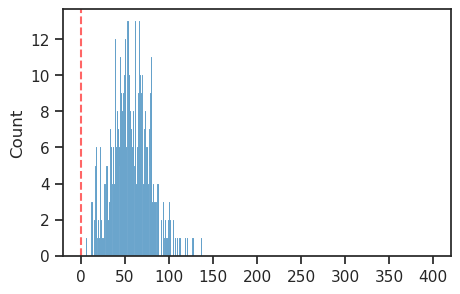

In [11]:
upper_lim = 400
ax = sns.histplot(loss['kl_diag'] * 1000, bins=np.linspace(0, upper_lim, upper_lim + 1))
ax.locator_params(axis='x', nbins=15)
ax.axvline(dead_thres * 1000, color='r', ls='--', alpha=0.6)
plt.show()

### Spike counts

In [12]:
lifetime, population, percents = sparse_score(data['z'], cutoff=0.01)
percents

{'0': 92.7, '1': 6.0, '2': 0.8, '3+': 0.5}

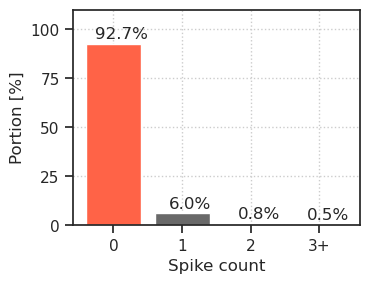

In [13]:
fig, ax = create_figure(1, 1, (3.7, 2.8))

max_val = float(list(percents.values())[0])
ax.set(
    xlabel='Spike count',
    ylabel='Portion [%]',
    ylim=(0, (np.ceil(max_val / 10) + 1) * 10),
)

colors = ['tomato' if lbl == '0' else 'dimgrey' for lbl in percents]
bars = ax.bar(percents.keys(), percents.values(), color=colors)

for bar in bars:
    y = bar.get_height()
    x = bar.get_x() + 1.3 * bar.get_width() / 2
    plt.text(x, y + 1, f'{y:0.1f}%', ha='center', va='bottom')

ax.locator_params(axis='y', nbins=5)

ax.grid()
plt.show()

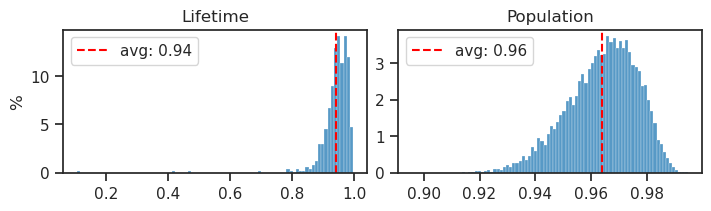

In [14]:
fig, axes = create_figure(1, 2, (7, 2), layout='constrained')

sns.histplot(lifetime, stat='percent', ax=axes[0])
sns.histplot(population, stat='percent', ax=axes[1])

for i, x2p in enumerate([lifetime, population]):
    _a, _med = np.nanmean(x2p), np.nanmedian(x2p)
    # axes[i].axvline(_med, color='g', ls='--', label=f'median: {_med:0.2f}')
    axes[i].axvline(_a, color='r', ls='--', label=f'avg: {_a:0.2f}')

add_legend(axes)
axes[0].set(title='Lifetime', ylabel='%')
axes[1].set(title='Population', ylabel='')
plt.show()

In [15]:
tot_nspks = data['z'][:, ~dead].sum(1)
tot_firing = (data['z'][:, ~dead] > 0).mean(1)

min(tot_nspks), max(tot_nspks)

(22.0, 104.0)

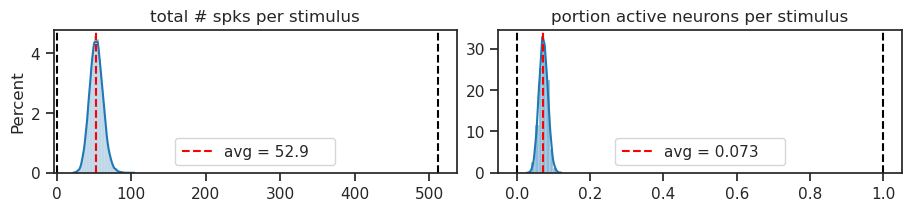

In [16]:
a = np.floor(min(tot_nspks) / 10) * 10
b = np.ceil(max(tot_nspks) / 10) * 10

fig, axes = create_figure(1, 2, (9, 2), layout='constrained')

sns.histplot(tot_nspks, bins=np.linspace(a, b, int(b - a) + 1), kde=True, stat='percent', ax=axes[0])
sns.histplot(tot_firing, bins=np.linspace(0, 1.0, 101), kde=True, stat='percent', ax=axes[1])

_a = tot_nspks.mean()
axes[0].axvline(_a, color='r', ls='--', label=f'avg = {_a:0.1f}    ')
_a = tot_firing.mean()
axes[1].axvline(_a, color='r', ls='--', label=f'avg = {_a:0.3f}    ')

axes[0].axvline(vae.cfg.n_latents, color='k', ls='--')
axes[1].axvline(1.0, color='k', ls='--')

axes[0].set_title('total # spks per stimulus')
axes[1].set(title='portion active neurons per stimulus', ylabel='')

for ax in axes.flat:
    ax.axvline(0, color='k', ls='--')
    ax.legend()
plt.show()

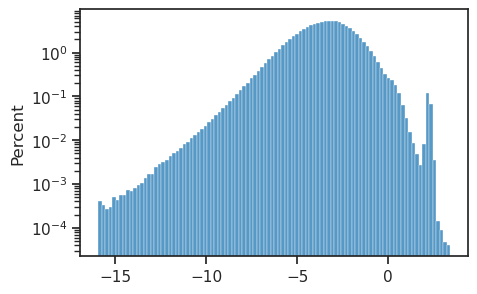

In [17]:
ax = sns.histplot(np.log(rates['r*dr'][:, ~dead].ravel()), stat='percent', bins=100)
ax.set_yscale('log')

### Plot enc/dec weights

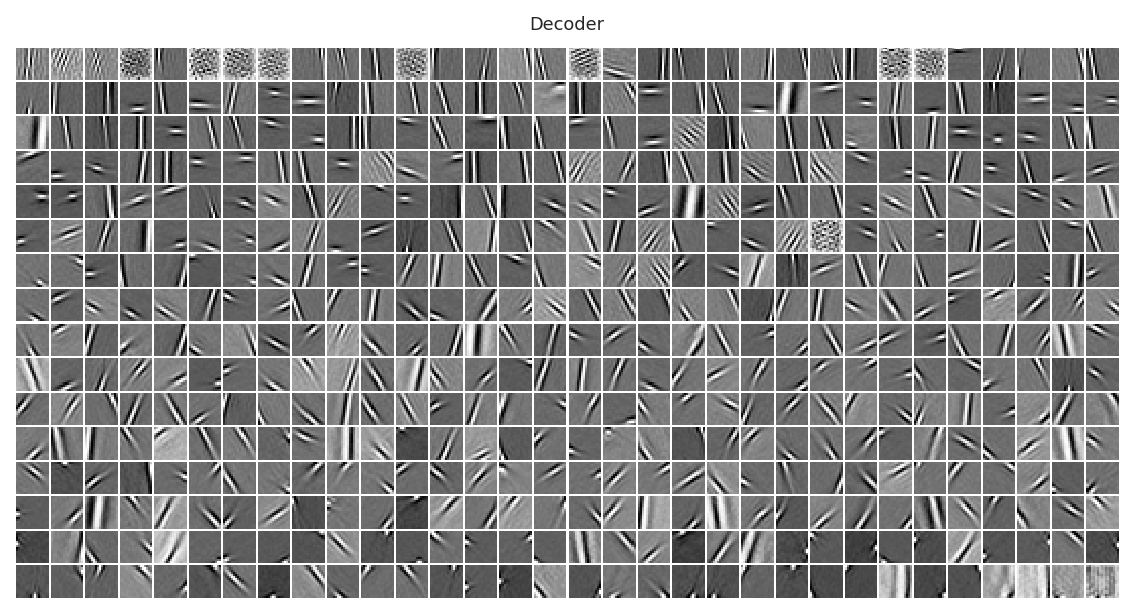

In [18]:
order = np.argsort(rates['r*dr'].mean(0))
vae.show(order=order);

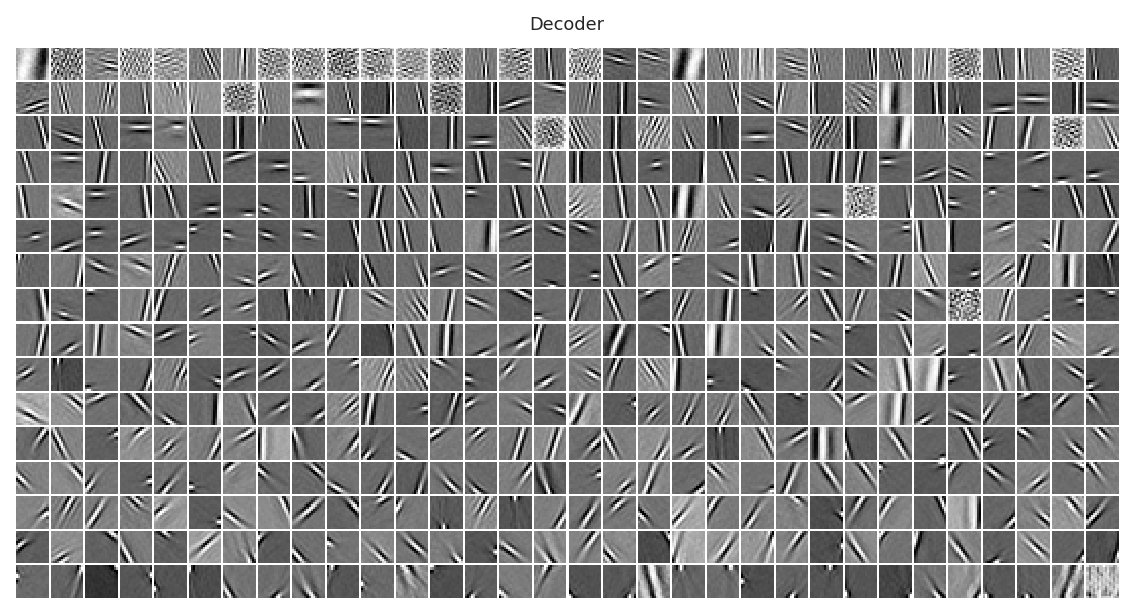

In [18]:
## Was rmax_q = 0.99

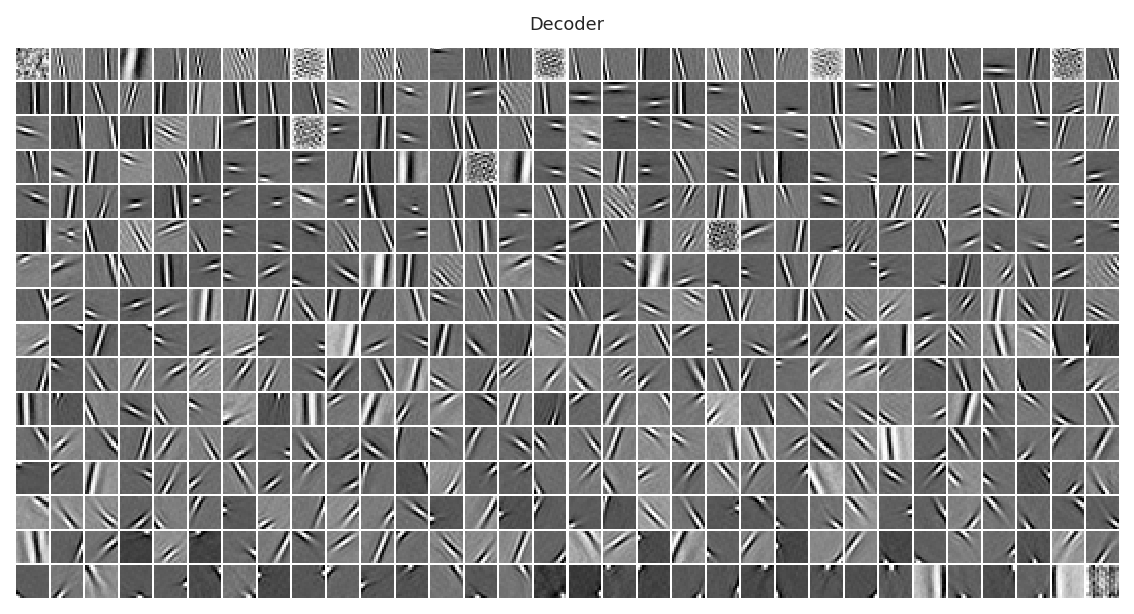

In [19]:
## Was rmax_q = 1.0

### Some more distributions

In [19]:
tr.model.temp, tr.cfg.kl_beta

(tensor(0.0505, device='cuda:0'), 1.0)

In [20]:
dead_thres = 0.001
dead = loss['kl_diag'] < dead_thres
dead.sum()

0

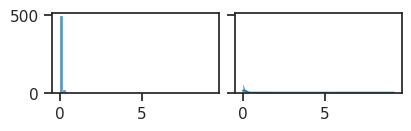

In [21]:
r8s = rates['r*dr'].mean(0)

fig, axes = create_figure(1, 2, (4, 1.2), sharey='all', layout='constrained')
sns.histplot(r8s[~dead], bins=50, ax=axes[0])
sns.histplot(r8s[~dead], bins=np.linspace(0, 1, 101), kde=True, ax=axes[1])
for ax in axes.flat:
    ax.set_ylabel('')
plt.show()

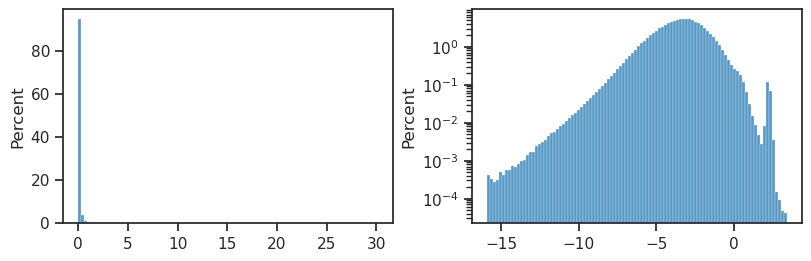

In [22]:
x2p = rates['r*dr'][:, ~dead].ravel()

fig, axes = create_figure(1, 2, (8, 2.5), layout='constrained')
sns.histplot(x2p, stat='percent', bins=100, ax=axes[0])
sns.histplot(np.log(x2p), stat='percent', bins=100, ax=axes[1])
axes[1].set_yscale('log')
plt.show()

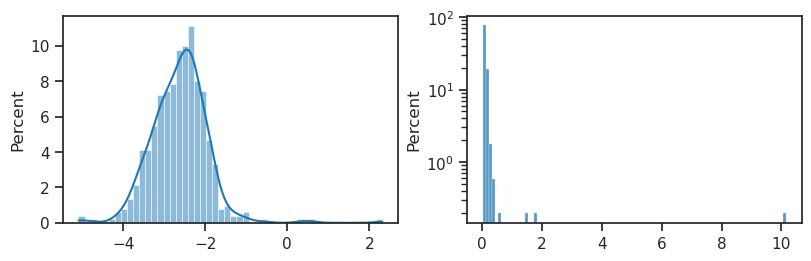

In [24]:
prior_rates = to_np(vae.log_rates)[:, ~dead].ravel()

fig, axes = create_figure(1, 2, (8, 2.5), layout='constrained')
sns.histplot(prior_rates, stat='percent', bins=50, kde=True, ax=axes[0])
sns.histplot(np.exp(prior_rates), stat='percent', bins=100, ax=axes[1])
axes[1].set_yscale('log')
plt.show()

In [48]:
prior_rates = to_np(vae.log_rates)[:, ~dead].ravel()

mu = prior_rates.mean()
sd = prior_rates.std()

rv = sp_stats.norm(loc=mu, scale=sd)
xs = np.linspace(-5.1, 2.4, 100)
pdf = rv.pdf(xs)

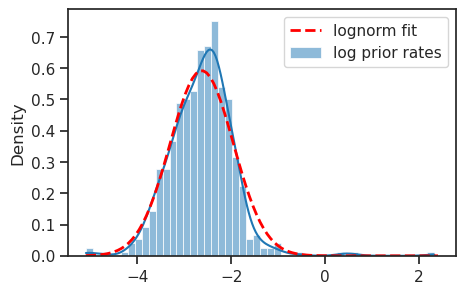

In [49]:
fig, ax = create_figure()

sns.histplot(prior_rates, stat='density', bins=50, kde=True, label='log prior rates', ax=ax)
ax.plot(xs, pdf, color='r', lw=2, ls='--', label='lognorm fit')
add_legend(ax)
plt.show()

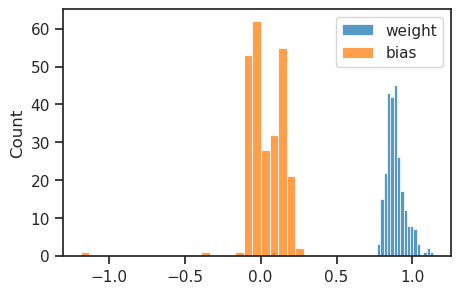

In [24]:
sns.histplot(to_np(vae.enc.layer_norm.weight), label='weight')
sns.histplot(to_np(vae.enc.layer_norm.bias), label='bias')
plt.legend()
plt.show()

<Axes: ylabel='Count'>

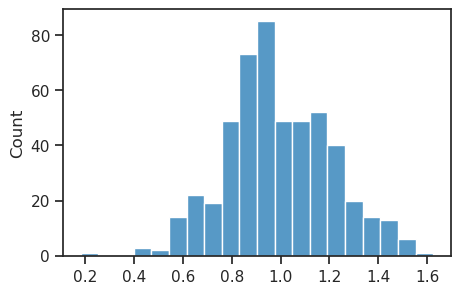

In [25]:
sns.histplot(to_np(torch.norm(vae.fc_dec.weight, dim=0)))